In [1]:
##   Project: Action Recognition using CNN + LSTM (UCF50 - 18 classes)
##  Goal: Classify videos based on actions using deep learning (TimeDistributed CNN + LSTM)
import pandas as pd
import os
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam

2025-12-05 05:10:24.252688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764911424.534627      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764911424.613433      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# import kagglehub

# # Download latest version
# # path = kagglehub.dataset_download("nipunarora8/age-gender-and-ethnicity-face-data-csv")
path="D:\sayantanroy10121999\anomalous-action-detection-dataset\1"

print("Path to dataset files:", path)

In [ ]:

DIRECTORY="D:\\sayantanroy10121999\\anomalous-action-detection-dataset\\1\\Anomalous Action Detection Dataset( Ano-AAD)\\abnormal class"
NORMAL_DIRECTORY="D:\\sayantanroy10121999\\anomalous-action-detection-dataset\\1\\Anomalous Action Detection Dataset( Ano-AAD)\\normal class - normal videos"
dataset_path = os.listdir(DIRECTORY)

# DIRECTORY="/kaggle/input/anomalous-action-detection-dataset/Anomalous Action Detection Dataset( Ano-AAD)/abnormal class"
# NORMAL_DIRECTORY="/kaggle/input/anomalous-action-detection-dataset/Anomalous Action Detection Dataset( Ano-AAD)/normal class - normal videos"
dataset_path = os.listdir(DIRECTORY)

label_types = os.listdir(DIRECTORY)
print (label_types)  


label_types_Normal = os.listdir(NORMAL_DIRECTORY)
print (label_types_Normal)  
selected_classes=label_types+label_types_Normal
selected_classes

['Arrest', 'Ill-treatment', 'Explosion', 'violence', 'Traffic Irregularities', 'Attack', 'Burglary', 'Fighting', 'fire-raising']
['Normal Videos']


['Arrest',
 'Ill-treatment',
 'Explosion',
 'violence',
 'Traffic Irregularities',
 'Attack',
 'Burglary',
 'Fighting',
 'fire-raising',
 'Normal Videos']

In [3]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir(DIRECTORY + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append(( str(DIRECTORY + '/' +item) + '/' + room,item))

for item in label_types_Normal:
 # Get all the file names
 all_rooms = os.listdir(NORMAL_DIRECTORY + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append(( str(NORMAL_DIRECTORY + '/' +item) + '/' + room,item))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=[ 'video_path','label'])
print(train_df.head())
print(train_df.tail())

                                          video_path   label
0  /kaggle/input/anomalous-action-detection-datas...  Arrest
1  /kaggle/input/anomalous-action-detection-datas...  Arrest
2  /kaggle/input/anomalous-action-detection-datas...  Arrest
3  /kaggle/input/anomalous-action-detection-datas...  Arrest
4  /kaggle/input/anomalous-action-detection-datas...  Arrest
                                            video_path          label
390  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
391  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
392  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
393  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
394  /kaggle/input/anomalous-action-detection-datas...  Normal Videos


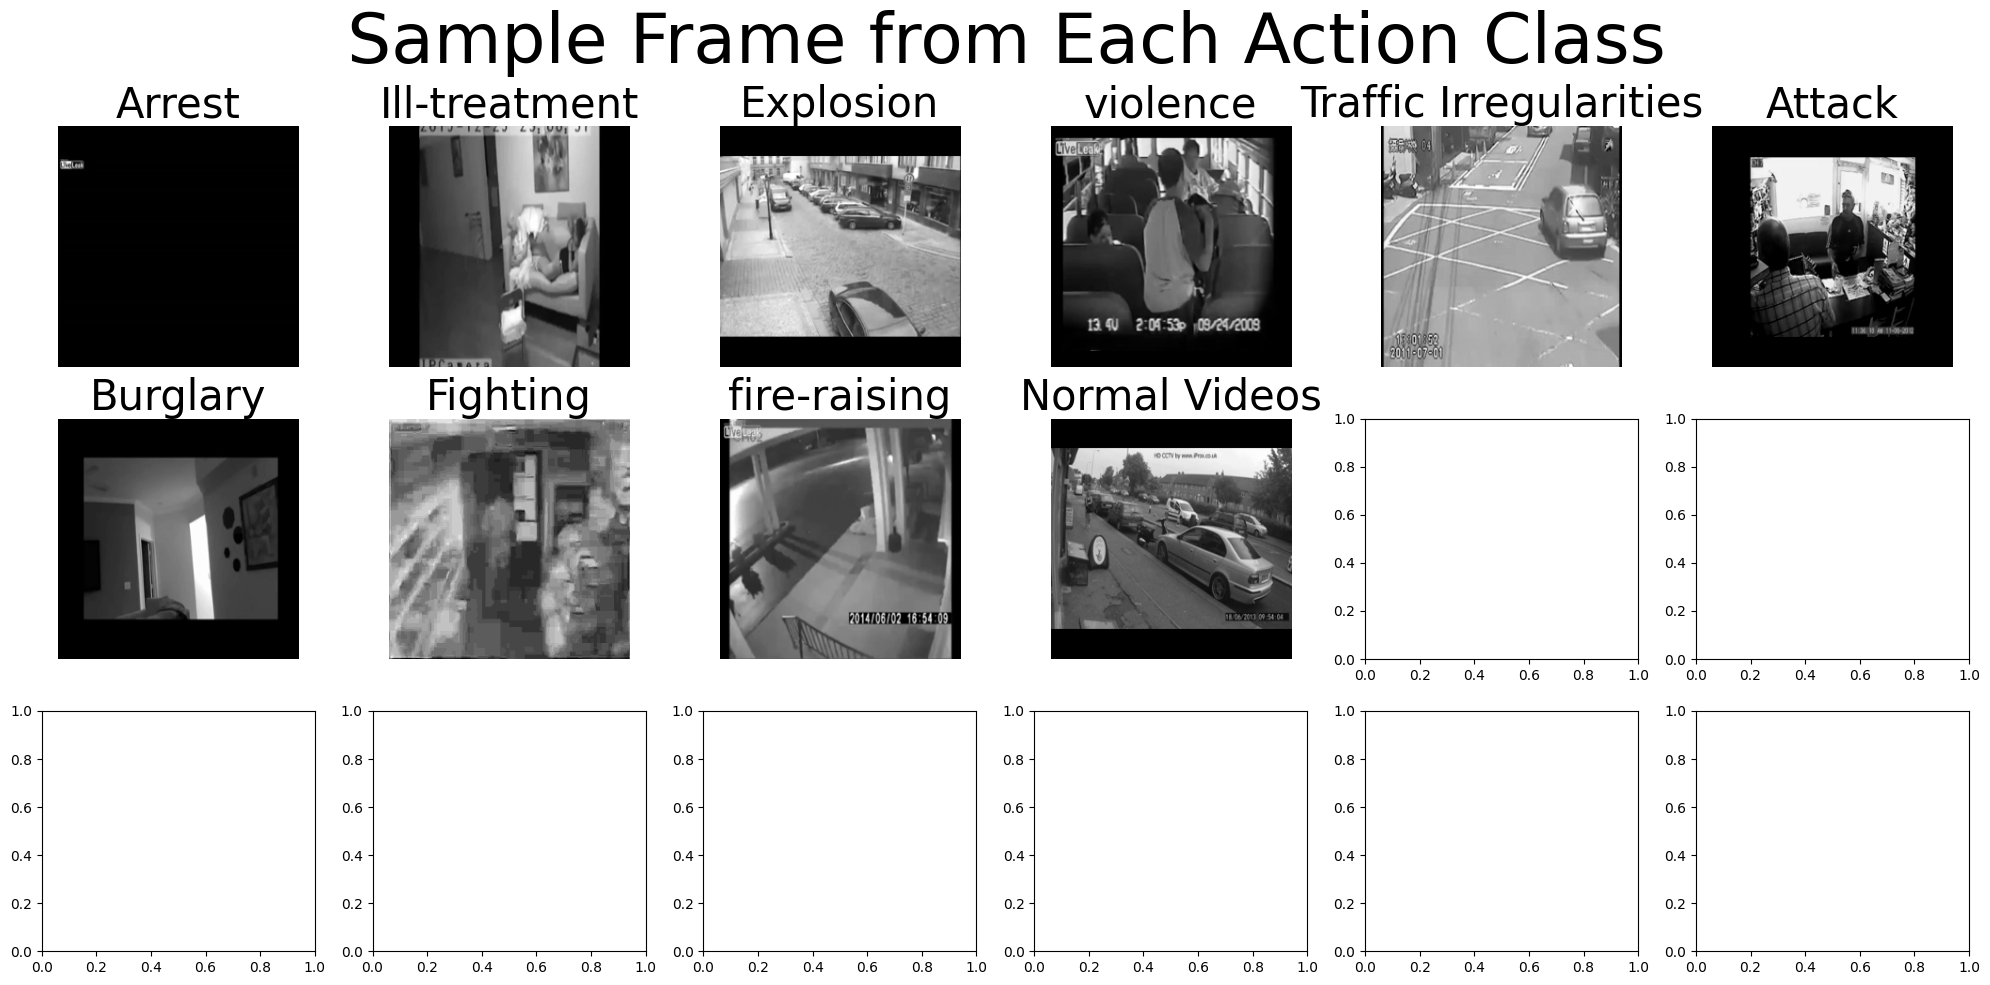

In [4]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        if(cls=="Normal Videos"):
            video_path = os.path.join(NORMAL_DIRECTORY, cls, os.listdir(os.path.join(NORMAL_DIRECTORY, cls))[0])
        else:
            video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame, cmap='gray')
            axes[i].set_title(cls, fontsize=30)
        axes[i].axis('off')
             

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, DIRECTORY)


In [5]:
#  Extract fixed number of frames from each video
# For simplicity and speed, we’ll extract 20 frames per video
Frame_Size=64

def extract_frames(video_path, num_frames=40):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)
    
    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (Frame_Size, Frame_Size))
            # frame = np.expand_dims(frame, axis=0) # Add channel dimension
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        count += 1
    cap.release()

    # Pad with last frame if video too short
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    return np.array(frames)


In [6]:
# Loop through videos in selected classes and extract frames
X = []
y = []

for class_index, cls in enumerate(selected_classes):
    if(cls=="Normal Videos"):
        class_path = os.path.join(NORMAL_DIRECTORY, cls)
        videos = os.listdir(class_path)  
        videos=videos[:30]
    else:
        class_path = os.path.join(DIRECTORY, cls)
        videos = os.listdir(class_path)  
        videos=videos[:30]
    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path, num_frames=40)
        if frames.shape == (40, Frame_Size, Frame_Size,3):  # Ensure consistent shape
            X.append(frames)
            y.append(class_index)


In [7]:

X = np.array(X)
y = to_categorical(y) # One-Hot

print(" Data Loaded:")
print("X shape:", X.shape)  # (samples, time_steps, height, width, channels)
print("y shape:", y.shape)  # (samples, num_classes)


 Data Loaded:
X shape: (279, 40, 64, 64, 3)
y shape: (279, 10)


In [8]:
print("y shape:", y.shape) 

y shape: (279, 10)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)  # shuffle the entire dataset first

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Training videos:", X_train.shape[0])
print("Testing videos:", X_test.shape[0])


Training videos: 223
Testing videos: 56


In [10]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# model = Sequential()

# # CNN feature extractor applied frame-wise (spatial features)
# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
#                           input_shape=(40, 64, 64, 3)))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))

# # LSTM for temporal feature extraction (temporal features)
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.5))

# # Final classification layer
# model.add(Dense(len(selected_classes), activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=0.003),
#               metrics=['accuracy'])

# # Freeze CNN feature extractor layers if needed
# for layer in model.layers[:4]:
#     layer.trainable = False


In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim):
        super().__init__()
        self.position_embeddings = tf.keras.layers.Embedding(sequence_length, output_dim)
    
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(0, length, 1)
        pos_embed = self.position_embeddings(positions)
        return inputs + pos_embed

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import keras
# selected_classes=10

@keras.saving.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, 
            output_dim=output_dim
        )

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        pos_embed = self.position_embeddings(positions)
        return inputs + pos_embed

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim
        })
        return config


def temporal_transformer(x, seq_len=40, num_heads=2, proj_dim=64, ff_dim=32):
    dim = x.shape[-1]
    x = Dense(proj_dim)(x)
    pos = PositionalEmbedding(seq_len, proj_dim)(x)
    n1 = LayerNormalization()(pos)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=proj_dim//num_heads)(n1, n1)
    add1 = pos + attn
    n2 = LayerNormalization()(add1)
    ff = Dense(ff_dim, activation='relu')(n2)
    return ff

# CNN backbone for spatial feature extraction
base = EfficientNetB0(
    include_top=False,
    weights='/kaggle/input/model1/other/default/1/efficientnetb0_notop.h5',
    input_shape=(Frame_Size, Frame_Size, 3),
    # pooling='avg'  # This is key - it gives us a feature vector per frame
)

# Model architecture
video_in = Input(shape=(40, Frame_Size, Frame_Size, 3))
x = tf.keras.layers.Flatten()(base.output)
x = TimeDistributed(base)(video_in)  # Now shape: (batch, 40, feature_dim)
x = TimeDistributed(Flatten())(x)
x = temporal_transformer(x, seq_len=40, num_heads=2, ff_dim=8)

x = LSTM(64)(x)
x = Dropout(0.5)(x)

# Classification head
out = Dense(len(selected_classes), activation='softmax')(x)

model = Model(video_in, out)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),  # Consider starting with a lower learning rate
    metrics=['accuracy']
)

# model.summary()

def extract_frames(video_path, max_frames=40, size=(Frame_Size,Frame_Size)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret or len(frames) >= max_frames:
            break
        frame = cv2.resize(frame, size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
    cap.release()
    if len(frames) == 0:
        return np.zeros((max_frames, size[1], size[0], 3), dtype=np.float32)
    while len(frames) < max_frames:
        frames.append(frames[-1])
    return np.array(frames[:max_frames])


2025-12-05 06:08:02.362505: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


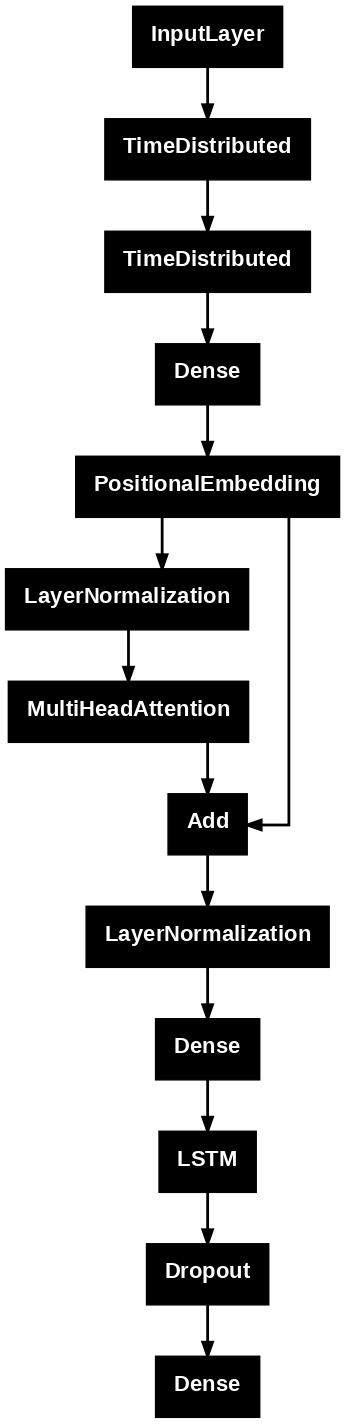

In [13]:
plot_model(model,dpi=100)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 40, 2, 2,  │  4,049,571 │ input_layer_1[0]… │
│ (TimeDistributed)   │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 40, 5120)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 64)    │    327,744 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 40, 64)    │      2,560 │ dense[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 40, 64)    │        128 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 64)    │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 8)     │        520 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     18,688 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        650 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,416,629 (16.85 MB)

 Trainable params: 4,374,606 (16.69 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [15]:
#  Train the model
# X_train.shape 
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # path to save the model
    monitor='val_loss',     # metric to monitor
    save_best_only=True,    # save only when the model improves
    mode='min',             # minimize val_loss
    verbose=1
)
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), batch_size=16,callbacks=[checkpoint])


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1016 - loss: 2.3282
Epoch 1: val_loss improved from inf to 2.36117, saving model to best_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1619s 20s/step - accuracy: 0.1023 - loss: 2.3273 - val_accuracy: 0.0893 - val_loss: 2.3612
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1528 - loss: 2.2268
Epoch 2: val_loss did not improve from 2.36117
14/14 ━━━━━━━━━━━━━━━━━━━━ 102s 7s/step - accuracy: 0.1567 - loss: 2.2236 - val_accuracy: 0.0536 - val_loss: 2.4081
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2527 - loss: 2.0888
Epoch 3: val_loss did not improve from 2.36117
14/14 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.2529 - loss: 2.0889 - val_accuracy: 0.1071 - val_loss: 2.3687
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3704 - loss: 1.8825
Epoch 4: val_loss did not improve from 2.36117
14/14 ━━━━━━━━━━━━━━━━━━━━ 120s 9s/step - accuracy: 0.3672 - loss: 1.8883 - val_accuracy: 0.0893 - 

In [55]:
model1 = tf.keras.models.load_model("/kaggle/input/trainedmodel/other/default/1/mohib.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 235 variables whereas the saved optimizer has 468 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [95]:
model1.layers[1].layer

<Functional name=efficientnetb0, built=True>

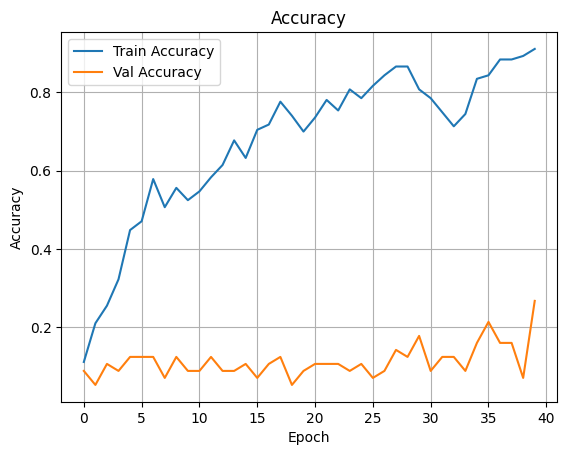

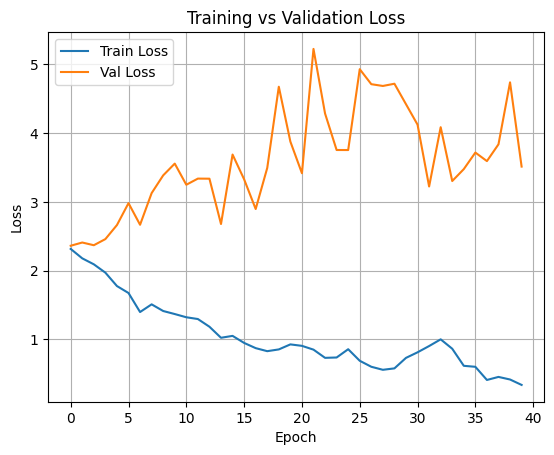

In [16]:
#  Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()    
plt.grid(True)
plt.show()

#  Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 372s 193s/step


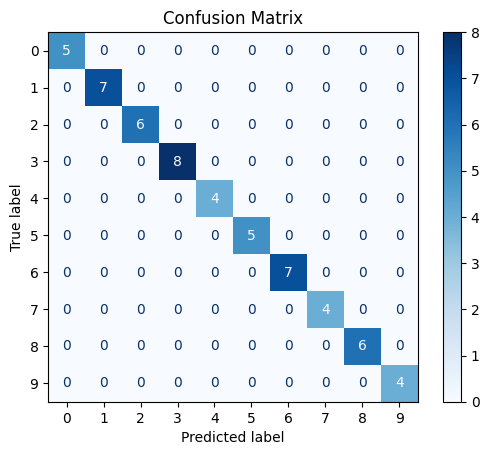

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_test, axis=1)  # if it's a classification model
y_true = np.argmax(y_test, axis=1)          # if y_test is one-hot encoded

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


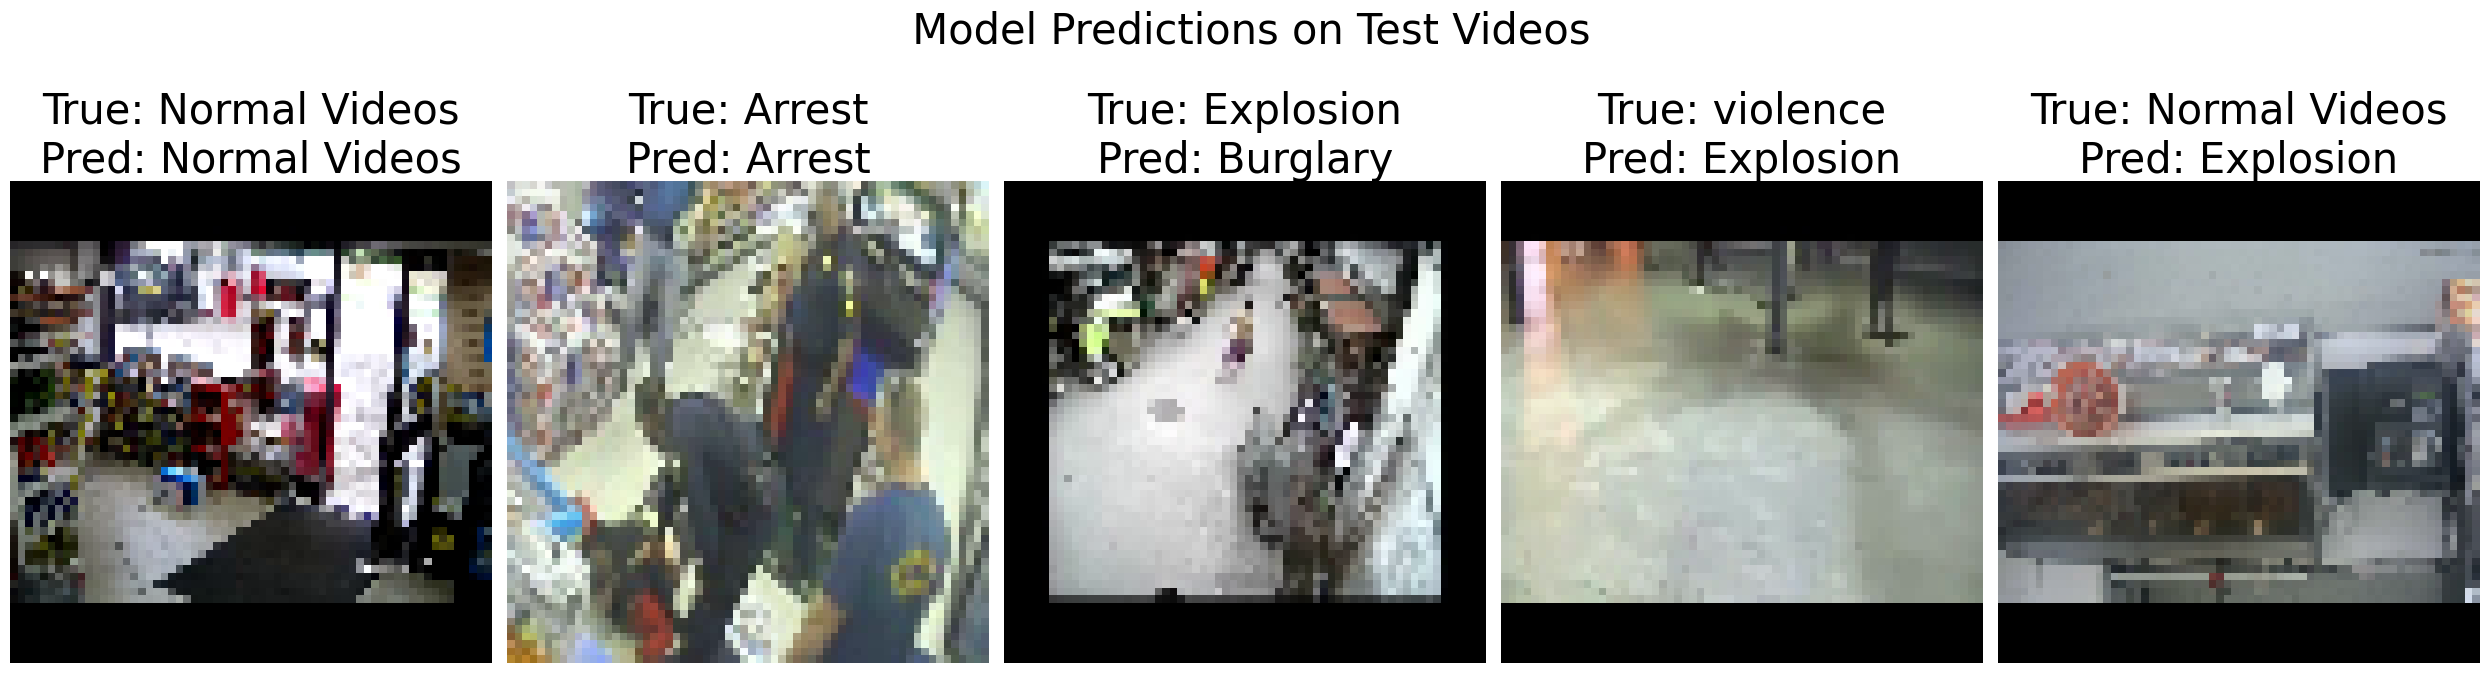

In [38]:
#  Visualize model predictions on 5 test videos (larger images)
def show_predictions(model, X_test, y_test, class_names):
    # Get 5 random indices
    indices = np.random.choice(len(X_test), 5, replace=False)
    
    # Bigger canvas size
    fig, axes = plt.subplots(1, 5, figsize=(25, 8))  #  Wider and taller

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = class_names[np.argmax(y_test[idx])]

        # Predict
        prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Get middle frame and denormalize
        mid_frame = video[len(video) // 2]
        mid_frame = (mid_frame * 255).astype(np.uint8)

        # Optional: remove resizing if frame is already big enough
        # frame = cv2.resize(mid_frame, (256, 256))  # or skip this
        frame = mid_frame  # Show full original frame size

        # Plot
        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=30)
        axes[i].axis('off')

    plt.suptitle(" Model Predictions on Test Videos", fontsize=30)
    plt.tight_layout()
    plt.show()

#  Run it
show_predictions(model, X_test, y_test, selected_classes)


In [31]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert predictions and labels back to class indices
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Overall Accuracy:", accuracy)

# Print precision, recall, and F1-score for each class
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Overall Accuracy: 0.26785714285714285

Classification Report:

              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.25      0.14      0.18         7
           2       0.08      0.17      0.11         6
           3       0.57      0.50      0.53         8
           4       1.00      0.25      0.40         4
           5       0.00      0.00      0.00         5
           6       0.40      0.29      0.33         7
           7       0.12      0.25      0.17         4
           8       1.00      0.17      0.29         6
           9       0.25      0.50      0.33         4

    accuracy                           0.27        56
   macro avg       0.41      0.27      0.27        56
weighted avg       0.41      0.27      0.28        56



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Overall Accuracy: 0.26785714285714285

Classification Report:

              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.25      0.14      0.18         7
           2       0.08      0.17      0.11         6
           3       0.57      0.50      0.53         8
           4       1.00      0.25      0.40         4
           5       0.00      0.00      0.00         5
           6       0.40      0.29      0.33         7
           7       0.12      0.25      0.17         4
           8       1.00      0.17      0.29         6
           9       0.25      0.50      0.33         4

    accuracy                           0.27        56
   macro avg       0.41      0.27      0.27        56
weighted avg       0.41      0.27      0.28        56



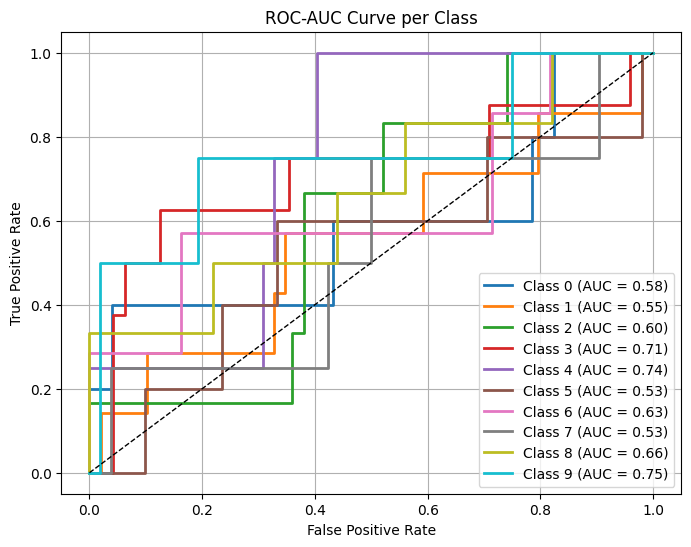

Overall Macro ROC-AUC: 0.6295


In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# === Performance Metrics ===
print("Overall Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

# === AUC (per class and micro/macro averages) ===
n_classes = y_test.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# === Plot AUC Curve ===
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC-AUC Curve per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === Overall ROC-AUC ===
overall_auc = roc_auc_score(y_test, y_pred, average='macro')
print(f"Overall Macro ROC-AUC: {overall_auc:.4f}")


In [102]:
import torch
from torch import nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        m=efficientnet_b0(weights=None)
        weights_path = "/kaggle/input/mymodels/other/default/1/efficientnet_b0_rwightman-7f5810bc.pth" # Replace with your actual path
        state_dict = torch.load(weights_path, map_location=torch.device('cpu')) # Load to CPU
        m.load_state_dict(state_dict)
        f = m.classifier[-1].in_features
        m.classifier[-1] = Identity()
        self.backbone = m
        self.rnn = nn.LSTM(f, 128, 1, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b*t, c, h, w)
        x = self.backbone(x)
        x = x.view(b, t, -1)
        o, (h, _) = self.rnn(x)
        o = o[:, -1]
        return self.fc(o)
class GradCam:
    def __init__(self, model):
        self.model = model
        self.fmap = None
        self.grad = None
        # layer = model.backbone.layer4[-1]
        layer = model.backbone.features[8][0]
        layer.register_forward_hook(self._fwd)
        layer.register_full_backward_hook(self._bwd)

    def _fwd(self, m, i, o):
        self.fmap = o

    def _bwd(self, m, gi, go):
        self.grad = go[0]

    def heatmap(self, x):
        y = self.model(x)
        cls = y.argmax(1)
        cams = []
        for i in range(x.size(0)):
            self.model.zero_grad()
            y[i, cls[i]].backward(retain_graph=True)
            g = self.grad[i].mean((1,2), keepdim=True)
            a = (self.fmap[i] * g).sum(0).relu()
            cams.append(a.detach().cpu())
        return torch.stack(cams)
    
    def heatmap_per_frame(self, x):
        """
        x shape: [1, T, 3, H, W]
        returns list of CAMs: length T
        """
        y = self.model(x)
        cls = y.argmax(1).item()

        self.model.zero_grad()
        y[0, cls].backward(retain_graph=True)

        fmap = self.fmap       # shape [T, C, Hf, Wf]
        grad = self.grad       # shape [T, C, Hf, Wf]

        cams = []
        for t in range(fmap.size(0)):
            g = grad[t].mean((1, 2), keepdim=True)
            a = (fmap[t] * g).sum(0).relu()
            cams.append(a.detach().cpu())

        return cams, cls


X = torch.tensor(X_train[:50], dtype=torch.float32).permute(0,1,4,2,3)
y = torch.tensor(y_train[:50].argmax(axis=1), dtype=torch.long)
print(y_train[:5])
print(y_train.shape)

model=Net(num_classes=10)
opt=torch.optim.Adam(model.parameters(),1e-4)
loss=nn.CrossEntropyLoss()

for epoch in range(50):
    o=model(X)
    l=loss(o,y)
    opt.zero_grad()
    l.backward()
    opt.step()

gcam=GradCam(model)
cam=gcam.heatmap(X)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(223, 10)


In [129]:
# pick one clip
clip = X_train[9:10]                # shape (1, T, 64, 64, 3)

clip = torch.tensor(clip, dtype=torch.float32).permute(0,1,4,2,3)

gcam = GradCam(model)
cams, pred_class = gcam.heatmap_per_frame(clip)

# print("Predicted class:", selected_classes[pred_class-1])


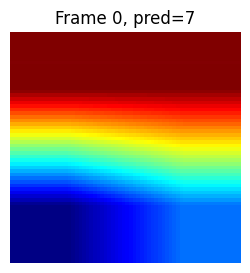

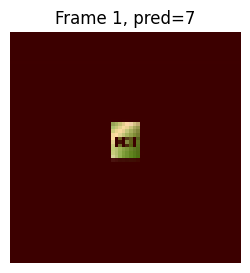

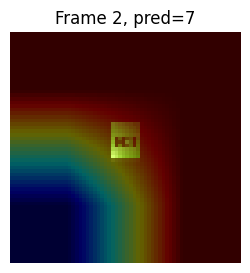

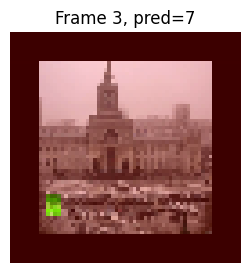

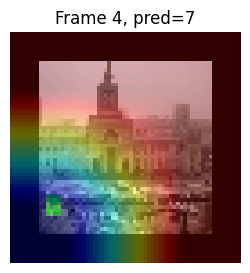

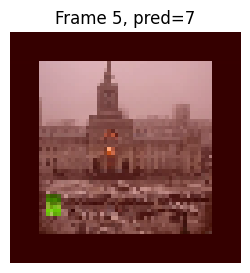

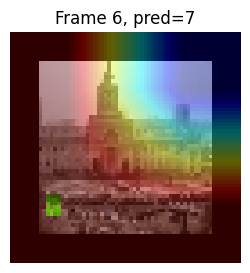

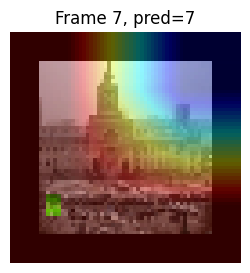

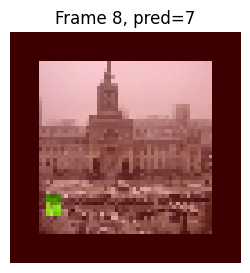

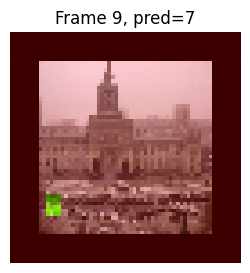

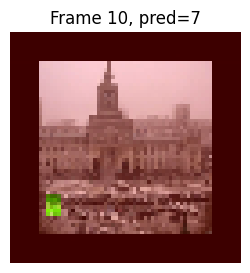

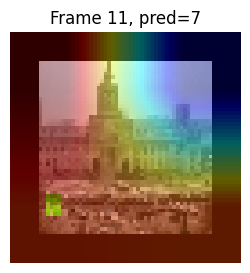

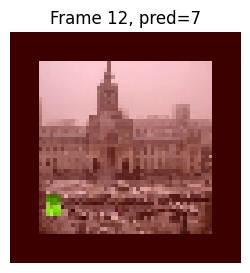

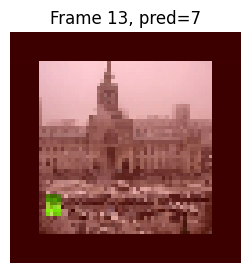

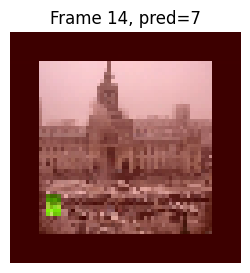

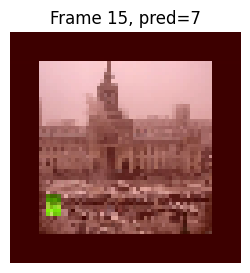

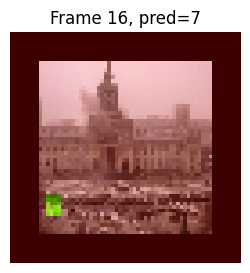

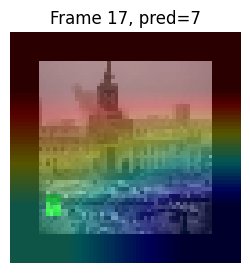

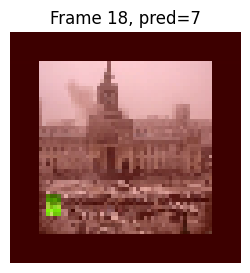

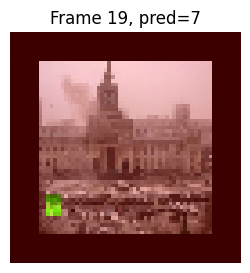

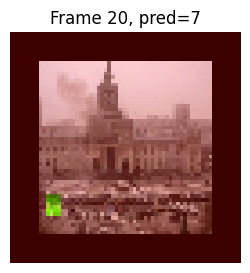

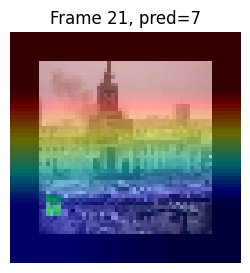

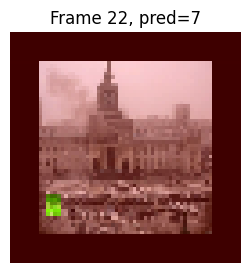

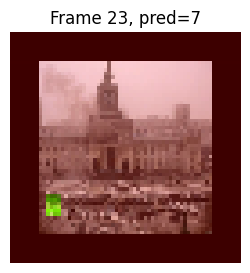

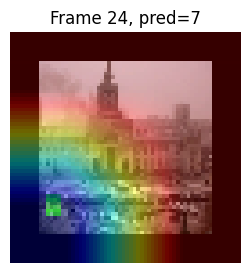

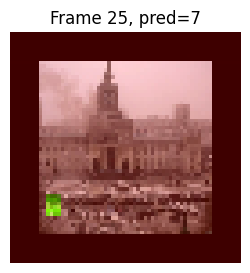

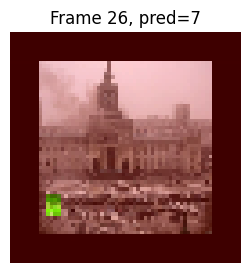

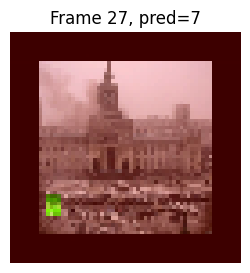

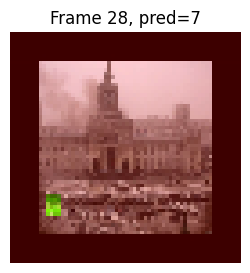

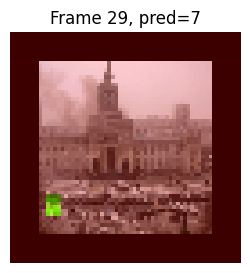

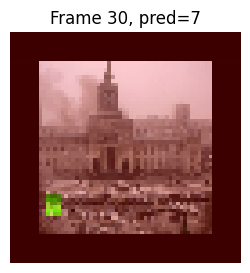

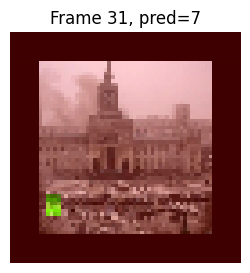

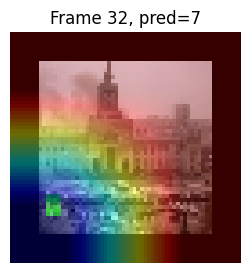

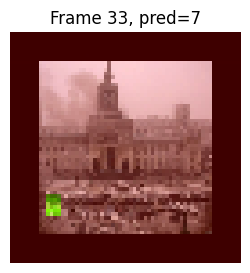

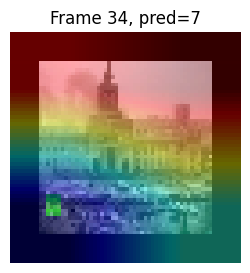

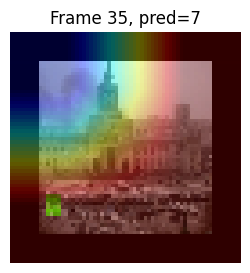

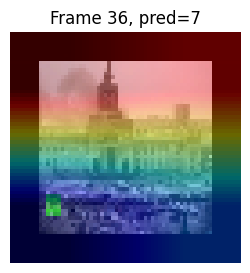

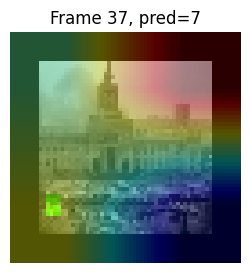

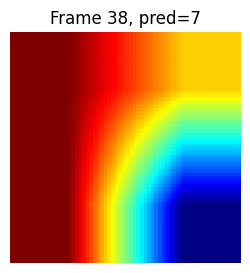

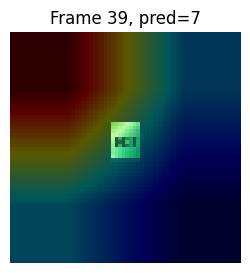

In [124]:
for t in range(len(cams)):
    img = clip[0, t].permute(1,2,0).cpu().numpy()

    hm = cams[t].numpy()
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)
    hm = cv2.resize(hm, (64, 64))
    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

    overlay = 0.5 * hm + 255 * img
    overlay = overlay / overlay.max()

    plt.figure(figsize=(3,3))
    plt.title(f"Frame {t}, pred={pred_class}")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])